In [1]:
import skimage
import numpy as np
import statistics

from glob import glob as show_dir_files
from scipy import ndimage as ndi
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from skimage.io import imread
from skimage.color import rgb2gray
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from skimage.measure import label, regionprops
from sklearn.metrics import pairwise_distances_argmin
from skimage import filters, measure, morphology, exposure

In [205]:
def plot_images(arr_images=[], grid=(2, 2), cmap="inferno"):

    if grid == None:
        
        length = len(arr_images)
        sqrt = int(np.sqrt(length))
        mult = int(length / sqrt)
        grid = (sqrt, mult)
        
    fig = plt.figure(figsize=(20, 10))

    grid = ImageGrid(fig, 111,
                     nrows_ncols=grid,
                     axes_pad=0.1)

    for ax, img in zip(grid, arr_images):
        ax.imshow(img, cmap)
        ax.axis('off')

    plt.show()

In [3]:
def smoothing_edges(mask):
    
    def find_bighest_cluster_area(clusters):
        regions = measure.regionprops(clusters)
        regions_area = map(lambda x: x.area, regions)
        return max(regions_area)

    #Converte em imagem binária
    mask = binarize_image(mask) 

    #Corrige imagem segmentada
    if statistics.mode(mask.flatten()):
        mask = np.invert(mask)

    #/ Seleciona maior objeto da imagem
    clusters = measure.label(mask, background=0)
    mask_size = find_bighest_cluster_area(clusters)
    mask = morphology.remove_small_objects(mask,
                                           min_size=(mask_size - 1),
                                           connectivity=16)
    #/
    
    #Conecta arestas proximas
    mask = morphology.closing(mask, morphology.disk(5))
    
    #Preenche buracos na imagem
    mask = ndi.binary_fill_holes(mask)
    
    #Aplica filtro de blur
    mask = filters.gaussian(mask, sigma=0.5)

    #Retorna a imagem bem delineada/refinada (smoothing)
    return binarize_image(mask)

In [4]:
def apply_k_means(image, n_colors=3):

    w, h, d = image.shape

    image_array = np.reshape(image, (w * h, d))

    image_array_sample = shuffle(image_array, random_state=0, n_samples=1_000)
    kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)

    labels = kmeans.predict(image_array)

    return kmeans.cluster_centers_[labels].reshape(w, h, -1)

def apply_k_random(image, n_colors=3):

    w, h, d = image.shape

    image_array = np.reshape(image, (w * h, d))

    codebook_random = shuffle(image_array, random_state=0, n_samples=n_colors)
   
    labels_random = pairwise_distances_argmin(codebook_random, image_array, axis=0)

    return codebook_random[labels_random].reshape(w, h, -1)


def apply_k_kmeans_gray(image, n_colors=3):
    
    k_means = KMeans(n_colors, n_init=4)
    k_means.fit(image.reshape((-1, 1)))
   
    values = k_means.cluster_centers_.squeeze()
    labels = k_means.labels_

    image_compressed = np.choose(labels, values)
    image_compressed.shape = image.shape
    
    return image_compressed

def normalize_image(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image))

def run_pipe(segmenter, image, n_colors=3):
    
    image_segments = segmenter(image, n_colors) #Aplicando K-means - Segmentando imagem.
    
    image_gray = image_segments.copy()
    
    if len(image_gray.shape) == 3:
        image_gray = rgb2gray(image_segments) #Convertando imagem RGB para Grayscale
    
    image_mask = smoothing_edges(image_gray) #Aplicando binarizador e smoothing de mask
    
    return image_segments, image_gray, image_mask

In [14]:
def binarize_image(arr):
    return arr > filters.threshold_triangle(arr)

def each_ch_hist(image):
    
    image_hist = image.copy()
    
    for ch in range(3):
        image_hist[:, :, ch] = exposure.equalize_hist(image[:, :, ch])
    
    return image_hist

In [55]:
def check_colision_border(mask):

    x, *_ = mask.shape

    left = mask[:1, ].flatten()
    right = mask[x - 1: x, ].flatten()
    top = mask[:, : 1].flatten()
    bottom = mask[:, x - 1: x].flatten()

    borders_flatten = [left, right, top, bottom]

    if np.concatenate(borders_flatten).sum():
        return True

    return False

def make_mask(image):
    def apply_thresh(image, block_size=1, thresh_type=199):
        return cv2.adaptiveThreshold(image, 
                                 255,
                                 cv2.ADAPTIVE_THRESH_MEAN_C,
                                 cv2.THRESH_BINARY_INV, 
                                 thresh_type, 
                                 block_size).astype(bool)
    mask = apply_thresh(image)
    
    if statistics.mode(mask.flatten()):
        mask = np.invert(mask)
    
    if check_colision_border(mask):
        for block in range(1, 30):

            mask = mask = apply_thresh(image, block)
            mask = find_best_larger_cluster(mask)
            
            if not check_colision_border(mask): break

    if statistics.mode(mask.flatten()):
        mask = np.invert(mask)
    
    mask = morphology.closing(mask, morphology.disk(3))

    mask = ndi.binary_fill_holes(mask)

    mask = filters.gaussian(mask, sigma=1.5)
    
    return binarize_image(mask)

def rescale_arr(arr, scale=255):
    return (arr * scale).astype('uint8')

In [ ]:
def apply_thresh(image, block_size=1, thresh_type=199):
    
    return cv2.adaptiveThreshold(image, 
                                 1,
                                 cv2.ADAPTIVE_THRESH_MEAN_C,
                                 cv2.THRESH_BINARY_INV, 
                                 thresh_type, 
                                 block_size).astype(bool)

In [207]:

def apply_segment_sobel_canny(img):
    
    image_eq = exposure.equalize_hist(img)
    
    sobel_mask = filters.sobel(image_eq)
    sobel_mask = smoothing_edges(sobel_mask)
    
    if not check_colision_border(sobel_mask):
        return sobel_mask
    
    canny_mask = feature.canny(image_eq, sigma=0)
    canny_mask = smoothing_edges(canny_mask)

    if check_colision_border(canny_mask):
        for sigma in range(0, 5):

            canny_mask = feature.canny(image_eq, sigma=sigma)
            canny_mask = smoothing_edges(canny_mask)

            if not check_colision_border(canny_mask): break
    
    return canny_mask

In [216]:
mask = apply_segment_sobel_canny(image_rescaled)

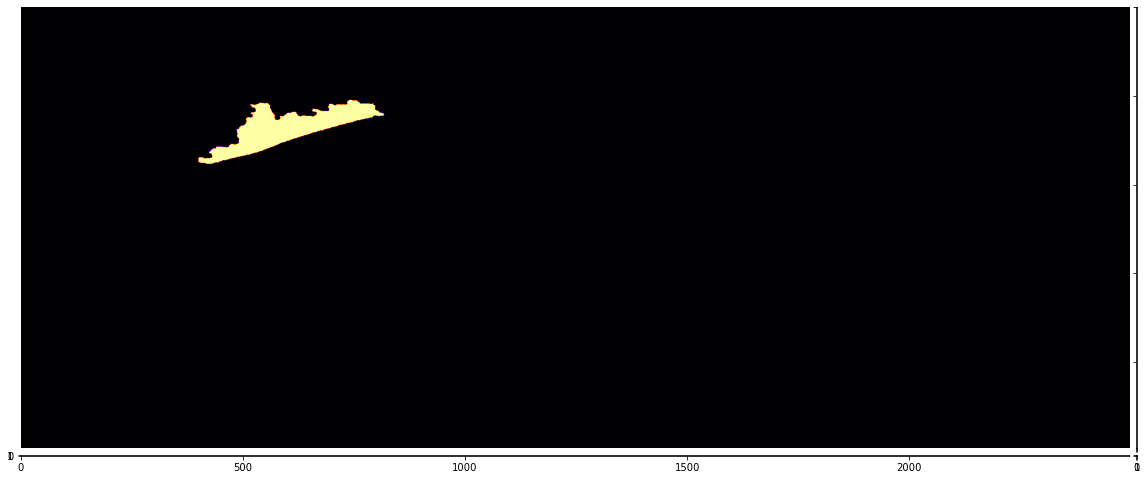

In [217]:
plot_images([mask])

In [210]:
image_origin = imread(show_dir_files("data/001_edited/*")[0])

image_gray = rgb2gray(image_origin)
image_rescaled = rescale_arr(image_gray)

all_masks = []

for block in range(11, 200, 10):

    mask = apply_thresh(image_rescaled, 1, thresh_type=block)
    
    all_masks.append(mask)

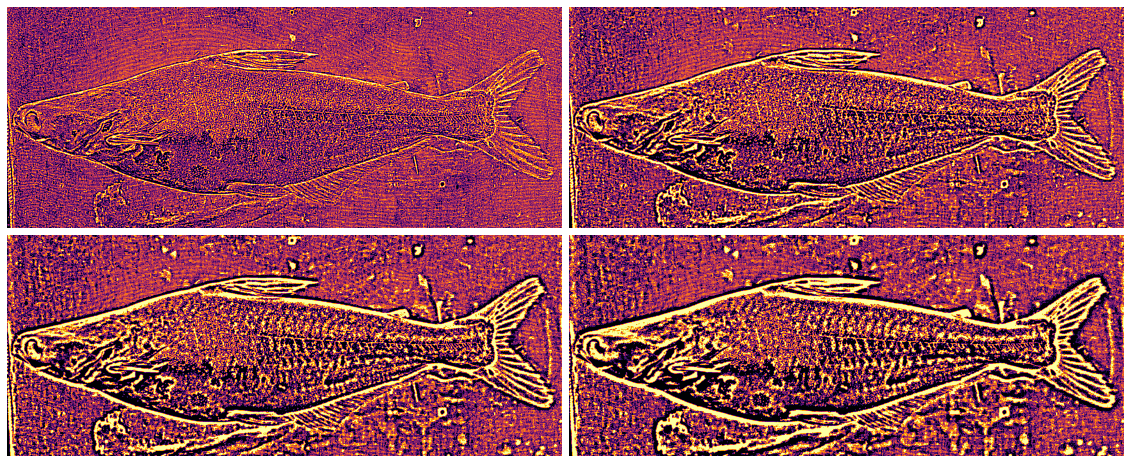

In [212]:
plot_images(all_masks)

In [202]:
length

19